In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
## SGD ##

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
## Momentum ##

In [14]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [6]:
## AdaGrad ##

In [7]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  # 0으로 나누는 것을 막기위해 1e-7을 넣음

In [9]:
## Adam ##

In [10]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

===========iteration:0===========
SGD:2.37316994182447
Momentum:2.460197141281312
AdaGrad:2.258113716954835
Adam:2.298737779072508
===========iteration:100===========
SGD:1.6591553621555253
Momentum:0.32577325406917546
AdaGrad:0.13155703405499683
Adam:0.2460021587223437
===========iteration:200===========
SGD:0.8333645817740026
Momentum:0.18394761901673146
AdaGrad:0.06602366283946542
Adam:0.11004960442541778
===========iteration:300===========
SGD:0.4884909684089053
Momentum:0.13632648250341742
AdaGrad:0.04152133602459798
Adam:0.11516674291059703
===========iteration:400===========
SGD:0.5254319144993527
Momentum:0.23643040867967405
AdaGrad:0.08101061888364988
Adam:0.12414965223755217
===========iteration:500===========
SGD:0.4175369139349756
Momentum:0.19907202028571958
AdaGrad:0.06982210317187314
Adam:0.15404684438767194
===========iteration:600===========
SGD:0.43180569982082984
Momentum:0.15919798839102084
AdaGrad:0.07495340089061778
Adam:0.135138251261665
===========iteration:700=

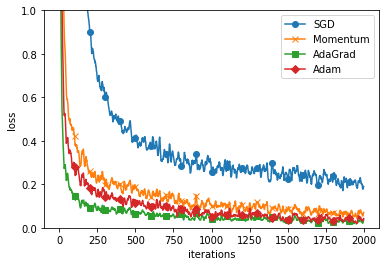

In [17]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from multi_layer_net import MultiLayerNet


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드 수
hidden_layer_size = 5           # 은닉층이 5개
activations = {}                # 활성화 값 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)  # Xavier 초기값 사용(앞의 노드 수 분의 1)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

print(activations)

{0: array([[0.45591062, 0.78319232, 0.44311702, ..., 0.67148706, 0.33184233,
        0.40344212],
       [0.35625086, 0.38274454, 0.18504061, ..., 0.84570623, 0.40513383,
        0.79443404],
       [0.45193662, 0.34141527, 0.64937262, ..., 0.57720164, 0.62229006,
        0.44898403],
       ...,
       [0.15988218, 0.15062235, 0.45871819, ..., 0.45191282, 0.67066891,
        0.53520849],
       [0.68001411, 0.75256593, 0.24232862, ..., 0.66192175, 0.27817711,
        0.25708027],
       [0.62227215, 0.56378939, 0.36441985, ..., 0.49186958, 0.17440924,
        0.3615396 ]]), 1: array([[0.55271037, 0.67240322, 0.51656762, ..., 0.39809334, 0.29291314,
        0.3870137 ],
       [0.58792553, 0.59101313, 0.52925911, ..., 0.35363654, 0.33219658,
        0.45706036],
       [0.53691173, 0.63480506, 0.51336886, ..., 0.33353943, 0.4729155 ,
        0.4548469 ],
       ...,
       [0.6335786 , 0.53337425, 0.60464704, ..., 0.38637775, 0.37040445,
        0.35025868],
       [0.55873734, 0.69017

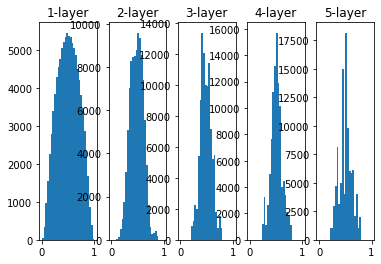

In [24]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()